### Import packages

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkt

### Define city and work folder

In [2]:
city_name='Los Angeles'

### Load file and convert to pd geodataframe (for visualizing results)

In [3]:
# Below is the Google File Drive Stream pathway for a mac. 
input_path = '/Volumes/GoogleDrive/My Drive/SPARCC/Data/Inputs/'
output_path = '~/git/sparcc/data/'
shp_folder = input_path+'shp/'+city_name+'/'

if city_name == 'Memphis':
    shp_name = 'cb_2017_47_tract_500k.shp'
elif city_name == 'Chicago':
    shp_name = 'cb_2017_17_tract_500k.shp'
elif city_name == 'Atlanta':
    shp_name = 'cb_2017_13_tract_500k.shp'
elif city_name == 'Denver':
    shp_name = 'cb_2017_08_tract_500k.shp'
elif city_name == 'Los Angeles':
    shp_name = 'cb_2017_06_tract_500k.shp'
city_shp = gpd.read_file(shp_folder+shp_name)

### read files
typology_input = pd.read_csv(output_path+city_name+'_database.csv', index_col = 0) ### Read file
city_shp = gpd.read_file(shp_folder+shp_name)


### Filter only census tracts of interest from shp
census_tract_list = typology_input['FIPS'].astype(str).str.zfill(11)
city_shp = city_shp[city_shp['GEOID'].isin(census_tract_list)].reset_index(drop = True)

city_shp['GEOID'] = city_shp['GEOID'].astype('int64')
typology_input = city_shp[['GEOID', 'geometry']].merge(typology_input, left_on = 'GEOID', right_on = 'FIPS')

data = typology_input.copy(deep=True)

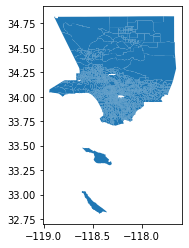

In [4]:
city_shp.plot()
plt.show()

## Summarize Income Categorization Data

In [5]:
data.groupby('inc_cat_medhhinc_17').count()['FIPS']

inc_cat_medhhinc_17
0.0     27
1.0    607
2.0    181
3.0      1
4.0    713
5.0    174
6.0    636
Name: FIPS, dtype: int64

In [6]:
data.groupby('inc_cat_medhhinc_00').count()['FIPS']

inc_cat_medhhinc_00
0.0      3
1.0    318
2.0    451
3.0      1
4.0    493
5.0    136
6.0    932
Name: FIPS, dtype: int64

## Run Typology Method

### Additional variable treatment

#### Flag for sufficient pop in tract by 2000

In [7]:
### The input file has a flag for 2017 population, but this step will generate the same flag for 2000
data['pop00flag'] = np.where((data['pop_00'] >500), 1, 0)

POPULATION OVER 500 FOR YEAR 2000


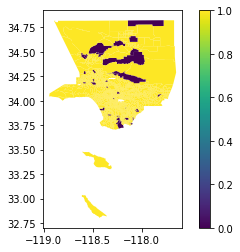

There are  38 census tract with pop<500 in 2000


In [8]:
print('POPULATION OVER 500 FOR YEAR 2000')
ax = data.plot(color = 'white')
ax = data.plot(ax = ax, column = 'pop00flag', legend = True)
plt.show()
print('There are ', len(data[data['pop00flag']==0]), 'census tract with pop<500 in 2000')

### Vulnerability to Gentrification

In [9]:
### Vulnerable to gentrification index, for both '90 and '00 - make it a flag

### ***** 1990 *****
### 2/4 Criteria that needs to be met
data['vul_gent_90'] = np.where(((data['aboverm_real_mrent_90']==0)|(data['aboverm_real_mhval_90']==0))&
                                 ((data['aboverm_per_all_li_90']+
                                   data['aboverm_per_nonwhite_90']+
                                   data['aboverm_per_rent_90']+
                                   (1-data['aboverm_per_col_90']))>1), 1, 0)


# ### ***** 2000 *****
# ### 2/4 Criteria that needs to be met
data['vul_gent_00'] = np.where(((data['aboverm_real_mrent_00']==0)|(data['aboverm_real_mhval_00']==0))&
                                 ((data['aboverm_per_all_li_00']+
                                   data['aboverm_per_nonwhite_00']+
                                   data['aboverm_per_rent_00']+
                                   (1-data['aboverm_per_col_00']))>1), 1, 0)

VULNERABLE IN 1990


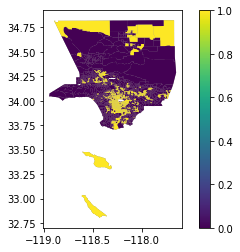

There are  0 census tract with NaN as data
There are  1010 census tracts vulnerable in 1990


In [10]:
print('VULNERABLE IN 1990')
ax = data.plot(color = 'grey')
ax = data[~data['vul_gent_90'].isna()].plot(ax = ax, column = 'vul_gent_90', legend = True)
plt.show()
print('There are ', data['vul_gent_90'].isna().sum(), 'census tract with NaN as data')
print('There are ', (data['vul_gent_90']==1).sum(), 'census tracts vulnerable in 1990')

VULNERABLE IN 2000


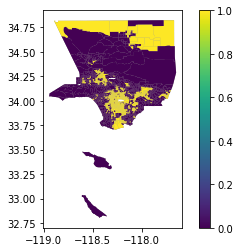

There are  0 census tract with NaN as data
There are  1152 census tracts vulnerable in 2000


In [11]:
print('VULNERABLE IN 2000')
ax = data.plot(color = 'grey')
ax = data[~data['vul_gent_00'].isna()].plot(ax = ax, column = 'vul_gent_00', legend = True)
plt.show()
print('There are ', data['vul_gent_00'].isna().sum(), 'census tract with NaN as data')
print('There are ', (data['vul_gent_00']==1).sum(), 'census tracts vulnerable in 2000')

###### Out of curiosity

In [12]:
### Out of curiosity
data['vulnerable'] = data['vul_gent_90']*data['vul_gent_00']

VULNERABLE IN BOTH YEARS


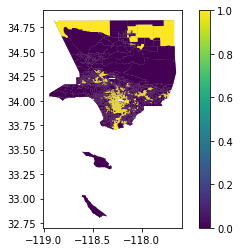

There are  0 census tract with NaN as data
There are  883 census tracts vulnerable in both years


In [13]:
print('VULNERABLE IN BOTH YEARS')
ax = data.plot(color = 'grey')
ax = data[~data['vulnerable'].isna()].plot(ax = ax, column = 'vulnerable', legend = True)
plt.show()
print('There are ', data['vulnerable'].isna().sum(), 'census tract with NaN as data')
print('There are ', (data['vulnerable']==1).sum(), 'census tracts vulnerable in both years')

### Hot Market

In [14]:
### Hot market in '00 and '17 - make it a flag:
### Using old methodology for now, will update later
### New methodology would be rapid increase (2013-2017)

data['hotmarket_00'] = np.where((data['aboverm_pctch_real_mhval_90_00']==1)|
                                  (data['aboverm_pctch_real_mrent_90_00']==1), 1, 0)
data['hotmarket_00'] = np.where((data['aboverm_pctch_real_mhval_90_00'].isna())|
                                  (data['aboverm_pctch_real_mrent_90_00'].isna()), np.nan, data['hotmarket_00'])

data['hotmarket_17'] = np.where((data['aboverm_pctch_real_mhval_00_17']==1)|
                                  (data['aboverm_pctch_real_mrent_00_17']==1), 1, 0)
data['hotmarket_17'] = np.where((data['aboverm_pctch_real_mhval_00_17'].isna())|
                                  (data['aboverm_pctch_real_mrent_00_17'].isna()), np.nan, data['hotmarket_17'])

HOT MARKET 2017


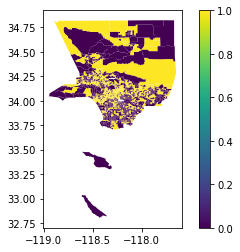

There are  0 census tract with NaN as data
There are  1196 census tracts with hot market in 2017


In [15]:
print('HOT MARKET 2017')
ax = data.plot(color = 'white')
ax = data[~data['hotmarket_17'].isna()].plot(ax = ax, column = 'hotmarket_17', legend = True)
plt.show()
print('There are ', data['hotmarket_17'].isna().sum(), 'census tract with NaN as data')
print('There are ', (data['hotmarket_17']==1).sum(), 'census tracts with hot market in 2017')

HOT MARKET 2000


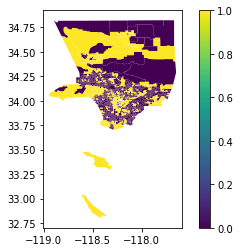

There are  0 census tract with NaN as data
There are  1031 census tracts with hot market in 2000


In [16]:
print('HOT MARKET 2000')
ax = data.plot(color = 'white')
ax = data[~data['hotmarket_00'].isna()].plot(ax = ax, column = 'hotmarket_00', legend = True)
plt.show()
print('There are ', data['hotmarket_00'].isna().sum(), 'census tract with NaN as data')
print('There are ', (data['hotmarket_00']==1).sum(), 'census tracts with hot market in 2000')

### Gentrification

In [17]:
### 2 out of 3 required
### 1990 - 2000
# data['gent_90_00'] = np.where((data['vul_gent_90']==1)&
#                                 ((data['aboverm_ch_per_col_90_00']+
#                                 data['aboverm_pctch_real_hinc_90_00']+
#                                 data['lostli_00'])>1)&
#                                 (data['hotmarket_00']==1), 1, 0)

# # 2000 - 2017
# data['gent_00_17'] = np.where((data['vul_gent_00']==1)&
#                                 ((data['aboverm_ch_per_col_00_17']+
#                                 data['aboverm_pctch_real_hinc_00_17']+
#                                 data['lostli_17'])>1)&
#                                 (data['ch_per_limove_12_17']<0)&
#                                 (data['hotmarket_17']==1), 1, 0)


### all required
### 1990 - 2000
data['gent_90_00'] = np.where((data['vul_gent_90']==1)&
                                (data['aboverm_ch_per_col_90_00']==1)&
                                (data['aboverm_pctch_real_hinc_90_00']==1)&
                                (data['lostli_00']==1)&
                                (data['hotmarket_00']==1), 1, 0)


# # 2000 - 2017
data['gent_00_17'] = np.where((data['vul_gent_00']==1)&
                                (data['aboverm_ch_per_col_00_17']==1)&
                                (data['aboverm_pctch_real_hinc_00_17']==1)&
                                (data['lostli_17']==1)&
                                (data['ch_per_limove_12_17']<0)&
                                (data['hotmarket_17']==1), 1, 0)

GENTRIFICATION 1990 - 2000


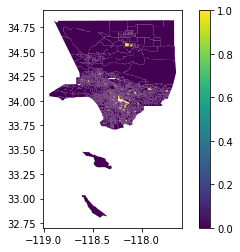

There are  0 census tract with NaN as data
60 census tracts were gentrified 1990-2000


In [18]:
print('GENTRIFICATION 1990 - 2000')
ax = data.plot(color = 'white')
ax = data[~data['gent_90_00'].isna()].plot(ax = ax, column = 'gent_90_00', legend = True)
plt.show()
print('There are ', data['gent_90_00'].isna().sum(), 'census tract with NaN as data')
print(str((data['gent_90_00']==1).sum()), 'census tracts were gentrified 1990-2000')

GENTRIFICATION 2000 - 2017


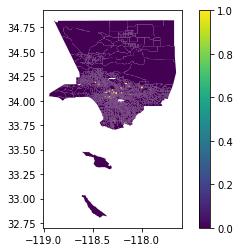

There are  0 census tract with NaN as data
51 census tracts were gentrified 2000-2017


In [19]:
print('GENTRIFICATION 2000 - 2017')
ax = data.plot(color = 'white')
ax = data[~data['gent_00_17'].isna()].plot(ax = ax, column = 'gent_00_17', legend = True)
plt.show()
print('There are ', data['gent_00_17'].isna().sum(), 'census tract with NaN as data')
print(str((data['gent_00_17']==1).sum()), 'census tracts were gentrified 2000-2017')

In [20]:
(data['gent_00_17']*data['gent_90_00']).sum()

0

### Typology definitions

Make flags for each typology definition - goal is to make them flags so we can compare accross typologies to check if any are being double counted or missed. Note on missing data: will code it so that the typology is missing if any of the core data elements are missing, but for any additional risk or stability criteria, will be coded so that it pulls from a shorter list if any are missing so as not to throw it all out


#### Stable/Advanced Exclusive

In [21]:
### ********* Stable/advanced exclusive *************
df = data
df['SAE'] = 0
df['SAE'] = np.where((df['pop00flag']==1)&
                     (df['high_pdmt_medhhinc_00'] == 1)&
                     (df['high_pdmt_medhhinc_17'] == 1)&                 
                     (df['lmh_flag_encoded'] == 3)&
                     ((df['change_flag_encoded'] == 1)|(df['change_flag_encoded'] == 2)|
                     (df['change_flag_encoded'] == 3)), 1, 0)

df['SAE'] = np.where((df['pop00flag'].isna())|
                     (df['high_pdmt_medhhinc_00'].isna())|
                     (df['high_pdmt_medhhinc_17'].isna())|
                     (df['lmh_flag_encoded'].isna())|
                     (df['change_flag_encoded'].isna()), np.nan, df['SAE'])

# replace SAE=1 if A==1 & (A==1) & (B==1) & (C==5| D==6)& (E==18 | F==19 | G==20)

STABLE ADVANCED EXCLUSIVE


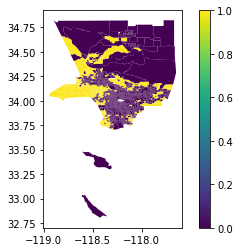

There are  5 census tract with NaN as data
There are  402 Stable Advanced Exclusive CT


In [22]:
print('STABLE ADVANCED EXCLUSIVE')
ax = data.plot(color = 'white')
ax = data[~data['SAE'].isna()].plot(ax = ax, column = 'SAE', legend = True)
plt.show()
print('There are ', data['SAE'].isna().sum(), 'census tract with NaN as data')
print('There are ',str((data['SAE']==1).sum()), 'Stable Advanced Exclusive CT')

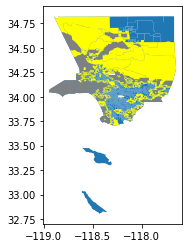

In [23]:
### Creates flag for proximity to exclusive neighborhood
### THIS IS NOT CURRENTLY BEING USED, BUT WILL BE USEFUL WHEN RISK FACTORS ARE INCLUDED

### Filters only exclusive tracts
exclusive = data[data['SAE']==1].reset_index(drop=True)

### Flags census tracts that touch exclusive tracts (excluding exclusive)
proximity = df[df.geometry.touches(exclusive.unary_union)]

ax = data.plot()
exclusive.plot(ax = ax, color = 'grey')
proximity.plot(ax = ax, color = 'yellow')
plt.show()

#### Advanced Gentrification

In [24]:
### ************* Advanced gentrification **************
df = data
df['AdvG'] = 0
df['AdvG'] = np.where((df['pop00flag']==1)&
                    ((df['mod_pdmt_medhhinc_17'] == 1)|(df['mix_mod_medhhinc_17'] == 1)|
                     (df['mix_high_medhhinc_17'] == 1)|(df['high_pdmt_medhhinc_17'] == 1))&                    
                    ((df['lmh_flag_encoded'] == 2)|(df['lmh_flag_encoded'] == 3)|
                     (df['lmh_flag_encoded'] == 5)|(df['lmh_flag_encoded'] == 6))&
                    ((df['change_flag_encoded'] == 1)|(df['change_flag_encoded'] == 2))&
                     ((df['gent_90_00']==1)|(df['gent_00_17']==1)), 1, 0)

df['AdvG'] = np.where((df['pop00flag'].isna())|
                     (df['mod_pdmt_medhhinc_17'].isna())|
                     (df['mix_mod_medhhinc_17'].isna())|
                     (df['mix_high_medhhinc_17'].isna())|
                     (df['high_pdmt_medhhinc_17'].isna())|
                     (df['lmh_flag_encoded'].isna())|
                     (df['change_flag_encoded'].isna())|
                     (df['gent_90_00'].isna())|
                     (df['gent_00_17'].isna()), np.nan, df['AdvG'])

df['AdvG'] = np.where((df['AdvG'] == 1)&(df['SAE']==1), 0, df['AdvG']) ### This is to account for double classification

ADVANCED GENTRIFICATION


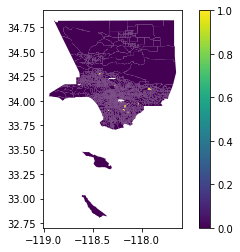

There are  0 census tract with NaN as data
There are  12 Advanced Gentrification CT


In [25]:
print('ADVANCED GENTRIFICATION')
ax = data.plot(color = 'white')
ax = data[~data['AdvG'].isna()].plot(ax = ax, column = 'AdvG', legend = True)
plt.show()
print('There are ', data['AdvG'].isna().sum(), 'census tract with NaN as data')
print('There are ',str((data['AdvG']==1).sum()), 'Advanced Gentrification CT')

#### At Risk of Becoming Exclusive

In [26]:
df = data
df['ARE'] = 0
df['ARE'] = np.where((df['pop00flag']==1)&
                    ((df['mod_pdmt_medhhinc_17'] == 1)|(df['mix_mod_medhhinc_17'] == 1)|
                     (df['mix_high_medhhinc_17'] == 1)|(df['high_pdmt_medhhinc_17'] == 1))&                    
                    ((df['lmh_flag_encoded'] == 2)|(df['lmh_flag_encoded'] == 3)|
                     (df['lmh_flag_encoded'] == 5)|(df['lmh_flag_encoded'] == 6))&
                    ((df['change_flag_encoded'] == 1)|(df['change_flag_encoded'] == 2)), 1, 0)

df['ARE'] = np.where((df['pop00flag'].isna())|
                     (df['mod_pdmt_medhhinc_17'].isna())|
                     (df['mix_mod_medhhinc_17'].isna())|
                     (df['mix_high_medhhinc_17'].isna())|
                     (df['high_pdmt_medhhinc_17'].isna())|
                     (df['lmh_flag_encoded'].isna())|
                     (df['change_flag_encoded'].isna()), np.nan, df['ARE'])

df['ARE'] = np.where((df['ARE'] == 1)&(df['AdvG']==1), 0, df['ARE']) ### This is to account for double classification
df['ARE'] = np.where((df['ARE'] == 1)&(df['SAE']==1), 0, df['ARE']) ### This is to account for double classification

AT RISK OF BECOMING EXCLUSIVE


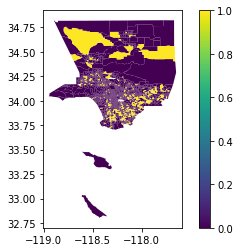

There are  0 census tract with NaN as data
There are  387 At Risk of Exclusive CT


In [27]:
print('AT RISK OF BECOMING EXCLUSIVE')
ax = data.plot(color = 'white')
ax = data[~data['ARE'].isna()].plot(ax = ax, column = 'ARE', legend = True)
plt.show()
print('There are ', data['ARE'].isna().sum(), 'census tract with NaN as data')
print('There are ',str((data['ARE']==1).sum()), 'At Risk of Exclusive CT')

#### Becoming Exclusive

In [28]:
### *********** Becoming exclusive *************
df['BE'] = 0
df['BE'] = np.where((df['pop00flag']==1)&
                    ((df['mod_pdmt_medhhinc_17'] == 1)|(df['mix_mod_medhhinc_17'] == 1)|
                     (df['mix_high_medhhinc_17'] == 1)|(df['high_pdmt_medhhinc_17'] == 1))&
                    ((df['lmh_flag_encoded'] == 2)|(df['lmh_flag_encoded'] == 3)|
                     (df['lmh_flag_encoded'] == 5)|(df['lmh_flag_encoded'] == 6))&
                     (df['change_flag_encoded'] == 3)&
                     (df['lostli_17']==1)&
                     (df['per_limove_17']<df['per_limove_12'])&
                     (df['real_hinc_17']>df['real_hinc_00']), 1, 0)

df['BE'] = np.where((df['pop00flag'].isna())|
                     (df['mod_pdmt_medhhinc_17'].isna())|
                     (df['mix_mod_medhhinc_17'].isna())|
                     (df['mix_high_medhhinc_17'].isna())|
                     (df['high_pdmt_medhhinc_17'].isna())|
                     (df['lmh_flag_encoded'].isna())|
                     (df['change_flag_encoded'].isna())|
                     (df['lostli_17'].isna())|
                     (df['per_limove_17'].isna())|
                     (df['per_limove_12'].isna())|
                     (df['real_hinc_17'].isna())|
                     (df['real_hinc_00'].isna()), np.nan, df['BE'])

df['BE'] = np.where((df['BE'] == 1)&(df['SAE']==1), 0, df['BE']) ### This is to account for double classification

BECOMING EXCLUSIVE


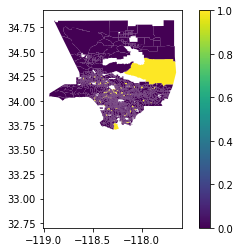

There are  42 census tract with NaN as data
There are  85 Becoming Exclusive CT


In [29]:
print('BECOMING EXCLUSIVE')
ax = data.plot(color = 'white')
ax = data[~data['BE'].isna()].plot(ax = ax, column = 'BE', legend = True)
plt.show()
print('There are ', data['BE'].isna().sum(), 'census tract with NaN as data')
print('There are ',str((data['BE']==1).sum()), 'Becoming Exclusive CT')

#### Stable Moderate/Mixed Income

In [30]:
df['SMMI'] = 0
df['SMMI'] = np.where((df['pop00flag']==1)&
                     ((df['mod_pdmt_medhhinc_17'] == 1)|(df['mix_mod_medhhinc_17'] == 1)|
                      (df['mix_high_medhhinc_17'] == 1)|(df['high_pdmt_medhhinc_17'] == 1))&             
                     (df['ARE']==0)&(df['BE']==0)&(df['SAE']==0)&(df['AdvG']==0), 1, 0)

df['SMMI'] = np.where((df['pop00flag'].isna())|
                      (df['mod_pdmt_medhhinc_17'].isna())|
                      (df['mix_mod_medhhinc_17'].isna())|
                      (df['mix_high_medhhinc_17'].isna())|
                      (df['high_pdmt_medhhinc_17'].isna()), np.nan, df['SMMI'])

Stable Moderate/Mixed Income


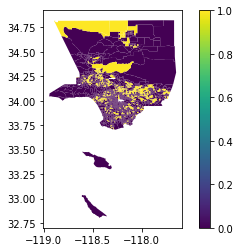

There are  0 census tract with NaN as data
There are  622 Stable Moderate/Mixed Income CT


In [31]:
print('Stable Moderate/Mixed Income')
ax = data.plot(color = 'white')
ax = data[~data['SMMI'].isna()].plot(ax = ax, column = 'SMMI', legend = True)
plt.show()
print('There are ', data['SMMI'].isna().sum(), 'census tract with NaN as data')
print('There are ',str((data['SMMI']==1).sum()), 'Stable Moderate/Mixed Income CT')

#### At Risk of Gentrification

In [32]:
df = data

### Needs to run exclusive code for analysis of risk factors
### ****ARG ****
df['ARG'] = 0
df['ARG'] = np.where((df['pop00flag']==1)&
                    ((df['low_pdmt_medhhinc_17']==1)|(df['mix_low_medhhinc_17']==1))&
                    ((df['lmh_flag_encoded']==1)|(df['lmh_flag_encoded']==4))&
                    ((df['change_flag_encoded'] == 1)|(df['change_flag_encoded'] == 2))&
                     (df['gent_90_00']==0)&
                     (df['gent_00_17']==0), 1, 0)

df['ARG'] = np.where((df['pop00flag'].isna())|
                     (df['low_pdmt_medhhinc_17'].isna())|
                     (df['mix_low_medhhinc_17'].isna())|
                     (df['lmh_flag_encoded'].isna())|
                     (df['change_flag_encoded'].isna())|
                     (df['gent_90_00'].isna())|
                     (df['gent_00_17'].isna()), np.nan, df['ARG'])

AT RISK OF GENTRIFICATION


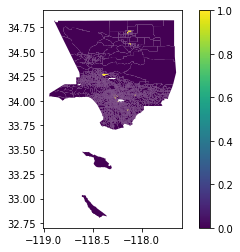

There are  0 census tract with NaN as data
There are  15 At Risk of Gentrification CT


In [33]:
print('AT RISK OF GENTRIFICATION')
ax = data.plot(color = 'white')
ax = data[~data['ARG'].isna()].plot(ax = ax, column = 'ARG', legend = True)
plt.show()
print('There are ', data['ARG'].isna().sum(), 'census tract with NaN as data')
print('There are ',str((data['ARG']==1).sum()), 'At Risk of Gentrification CT')

#### Early/Ongoing Gentrification

In [34]:
###************* Early/ongoing gentrification **************
### ****EOG ****
df['EOG'] = 0
df['EOG'] = np.where((df['pop00flag']==1)&
                    ((df['low_pdmt_medhhinc_17']==1)|(df['mix_low_medhhinc_17']==1))&
                     (df['ch_per_limove_12_17']<0)&                     
                    ((df['lmh_flag_encoded'] == 1)|(df['lmh_flag_encoded'] == 2)|
                     (df['lmh_flag_encoded'] == 4)|(df['lmh_flag_encoded'] == 5))&
                    ((df['change_flag_encoded'] == 2)|(df['change_flag_encoded'] == 3)|
                     (df['ab_50pct_ch'] == 1))&
                     ((df['gent_90_00']==1)|(df['gent_00_17']==1)), 1, 0)

df['EOG'] = np.where((df['pop00flag'].isna())|
                     (df['low_pdmt_medhhinc_17'].isna())|
                     (df['mix_low_medhhinc_17'].isna())|
                     (df['ch_per_limove_12_17'].isna())|
                     (df['lmh_flag_encoded'].isna())|
                     (df['change_flag_encoded'].isna())|
                     (df['gent_90_00'].isna())|
                     (df['gent_00_17'].isna())|
                     (df['ab_50pct_ch'].isna()), np.nan, df['EOG'])

EARLY/ONGOING GENTRIFICATION


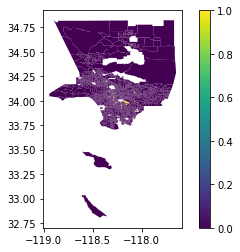

There are  28 census tract with NaN as data
There are  39 Early/Ongoing Gentrification CT


In [35]:
print('EARLY/ONGOING GENTRIFICATION')
ax = data.plot(color = 'white')
ax = data[~data['EOG'].isna()].plot(ax = ax, column = 'EOG', legend = True)
plt.show()
print('There are ', data['EOG'].isna().sum(), 'census tract with NaN as data')
print('There are ',str((data['EOG']==1).sum()), 'Early/Ongoing Gentrification CT')

#### Ongoing Displacement

In [36]:
df = data

df['OD'] = 0
df['OD'] = np.where((df['pop00flag']==1)&
                          ((df['low_pdmt_medhhinc_17']==1)|(df['mix_low_medhhinc_17']==1))&
                          (df['lostli_17']==1), 1, 0)

df['OD_loss'] = np.where((df['pop00flag'].isna())|
                    (df['low_pdmt_medhhinc_17'].isna())|
                    (df['mix_low_medhhinc_17'].isna())|
                    (df['lostli_17'].isna()), np.nan, df['OD'])

df['OD'] = np.where((df['OD'] == 1)&(df['ARG']==1), 0, df['OD']) ### This is to account for double classification
df['OD'] = np.where((df['OD'] == 1)&(df['EOG']==1), 0, df['OD']) ### This is to account for double classification

ONGOING DISPLACEMENT


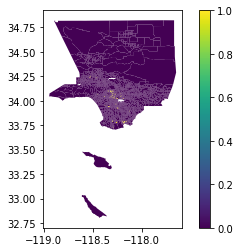

There are  0 census tract with NaN as data
There are  56 Ongoing Displacement CT


In [37]:
print('ONGOING DISPLACEMENT')
ax = data.plot(color = 'white')
ax = data[~data['OD'].isna()].plot(ax = ax, column = 'OD', legend = True)
plt.show()
print('There are ', data['OD'].isna().sum(), 'census tract with NaN as data')
print('There are ',str((data['OD']==1).sum()), 'Ongoing Displacement CT')

#### Stable/Low-Income

In [38]:
df['SLI'] = 0
df['SLI'] = np.where((df['pop00flag'] == 1)&
                     ((df['low_pdmt_medhhinc_17'] == 1)|(df['mix_low_medhhinc_17'] == 1))&
                     (df['OD']!=1) & (df['ARG']!=1) *(df['EOG']!=1), 1, 0)

/Users/annadriscoll/opt/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


STABLE LOW INCOME TRACTS


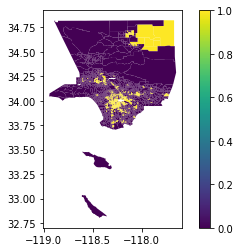

There are  0 census tract with NaN as data
There are  672 Stable Low Income CT


In [39]:
print('STABLE LOW INCOME TRACTS')
ax = data.plot(color = 'white')
ax = data[~data['SLI'].isna()].plot(ax = ax, column = 'SLI', legend = True)
plt.show()
print('There are ', data['SLI'].isna().sum(), 'census tract with NaN as data')
print('There are ',str((data['SLI']==1).sum()), 'Stable Low Income CT')

## Create Typology variables from all the dummies

In [40]:
df['double_counted'] = (df['SLI'].fillna(0) + df['OD'].fillna(0) + df['ARG'].fillna(0) + df['EOG'].fillna(0) +
                       df['AdvG'].fillna(0) + df['ARE'].fillna(0) + df['BE'].fillna(0) + df['SAE'] + df['SMMI'])
    
df['typology'] = np.nan
df['typology'] = np.where(df['SLI'] == 1, 1, df['typology'])
df['typology'] = np.where(df['OD'] == 1, 2, df['typology'])
df['typology'] = np.where(df['ARG'] == 1, 3, df['typology'])
df['typology'] = np.where(df['EOG'] == 1, 4, df['typology'])
df['typology'] = np.where(df['AdvG'] == 1, 5, df['typology'])
df['typology'] = np.where(df['SMMI'] == 1, 6, df['typology'])
df['typology'] = np.where(df['ARE'] == 1, 7, df['typology'])
df['typology'] = np.where(df['BE'] == 1, 8, df['typology'])
df['typology'] = np.where(df['SAE'] == 1, 9, df['typology'])
df['typology'] = np.where(df['double_counted']>1, 99, df['typology'])

#### Double Classification

In [41]:
cat_i = list()

df = data
for i in range (0, len (df)):
    categories = list()
    if df['SLI'][i] == 1:
        categories.append('SLI')
    if df['OD'][i] == 1:
        categories.append('OD')
    if df['ARG'][i] == 1:
        categories.append('ARG')
    if df['EOG'][i] == 1:
        categories.append('EOG')
    if df['AdvG'][i] == 1:
        categories.append('AdvG')
    if df['SMMI'][i] == 1:
        categories.append('SMMI')
    if df['ARE'][i] == 1:
        categories.append('ARE')
    if df['BE'][i] == 1:
        categories.append('BE')
    if df['SAE'][i] == 1:
        categories.append('SAE')
    cat_i.append(str(categories))
    
df['typ_cat'] = cat_i

In [42]:
df.groupby('typ_cat').count()['FIPS']

typ_cat
['ARE']     387
['ARG']      15
['AdvG']     12
['BE']       85
['EOG']      39
['OD']       56
['SAE']     402
['SLI']     672
['SMMI']    622
[]           49
Name: FIPS, dtype: int64

TYPOLOGIES


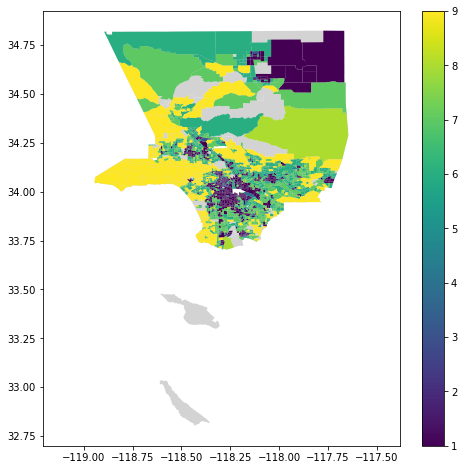

There are  49 census tract with NaN as data


In [43]:
print('TYPOLOGIES')

f, ax = plt.subplots(1, figsize=(8, 8))
data.plot(ax=ax, color = 'lightgrey')
lims = plt.axis('equal')
data[~data['typology'].isna()].plot(ax = ax, column = 'typology', legend = True)
plt.show()
print('There are ', data['typology'].isna().sum(), 'census tract with NaN as data')

In [44]:
data['FIPS'] = data['FIPS'].astype(str)
data = data.drop(columns = 'geometry')
data.to_csv(output_path+city_name+'_typology_output.csv')